# Membuat model klasifikasi untuk memprediksi pembayaran bulan selanjutnya dengan model KNN, SVC dan Logistic Regression

# Query Selection

```sql
SELECT
  limit_balance,
  CAST(sex AS INT64) AS sex,
  CAST(education_level AS INT64) AS education_level,
  CAST(marital_status AS INT64) AS marital_status,
  age,
  pay_0,
  pay_2,
  pay_3,
  pay_4,
  CAST(pay_5 AS FLOAT64) AS pay_5,
  CAST(pay_6 AS FLOAT64) AS pay_6,
  bill_amt_1,
  bill_amt_2,
  bill_amt_3,
  bill_amt_4,
  bill_amt_5,
  bill_amt_6,
  pay_amt_1,
  pay_amt_2,
  pay_amt_3,
  pay_amt_4,
  pay_amt_5,
  pay_amt_6,
  CAST(default_payment_next_month AS INT64) AS default_payment_next_month
FROM
  `bigquery-public-data.ml_datasets.credit_card_default`
  LIMIT 20000;
```


# Import Library

In [12]:
import pandas as pd
import numpy as np   
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sb
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

#Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Machine Learning Evaluation
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

# Data Loading

In [13]:
# Data Loading
database = pd.read_csv('dataset.csv')
database.info()
database.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0


Data memiliki 2965 baris dan 24 kolom

# Exploration Data Analysis

### Perbandingan yang Bayar dan Yang belum bayar

<Axes: xlabel='default_payment_next_month', ylabel='default_payment_next_month'>

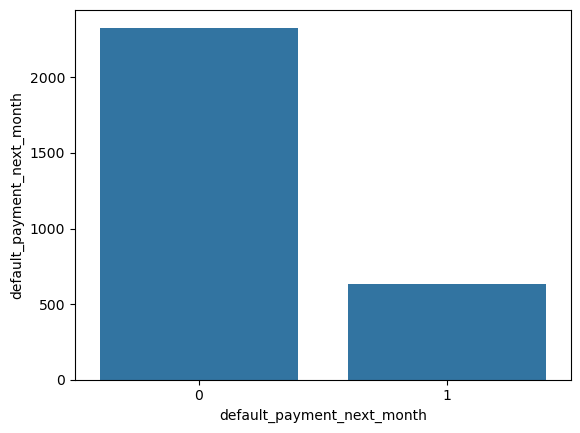

In [14]:
sb.barplot(data=database.groupby('default_payment_next_month')['default_payment_next_month'].size())

Lebih banyak yang Wanprestasi dibanding yang bukan

### Melihat Banyaknya Orang yang Wanprestasi berdasarkan gender

<Axes: xlabel='sex', ylabel='default_payment_next_month'>

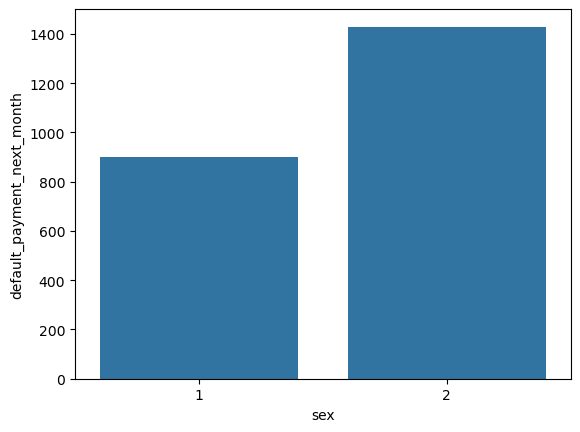

In [15]:
sb.barplot(data=database.query("default_payment_next_month == 0").groupby('sex')['default_payment_next_month'].size())

Data 'Sex' Index 2 Lebih banyak yang Wanprestasi dibanding yang Index 1

### Melihat Banyaknya orang yang Wanprestasi berdasarkan Tingkat Edukasi

<Axes: xlabel='education_level', ylabel='default_payment_next_month'>

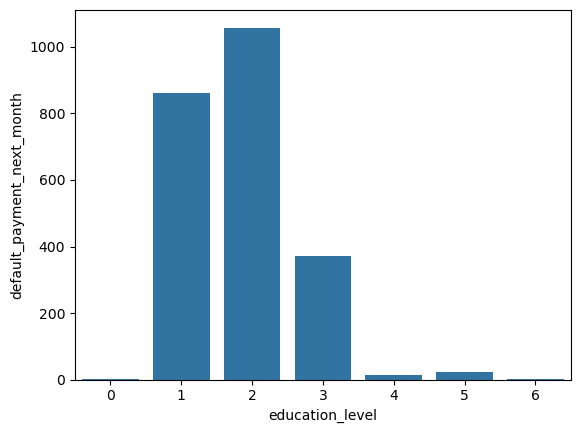

In [16]:
sb.barplot(data=database.query("default_payment_next_month == 0").groupby('education_level')['default_payment_next_month'].size())

Orang yang memiliki tingkat edukasi_level 2 lebih banyak yang wanprestasi

### Melihat banyaknya data pay yang negatif

<Axes: >

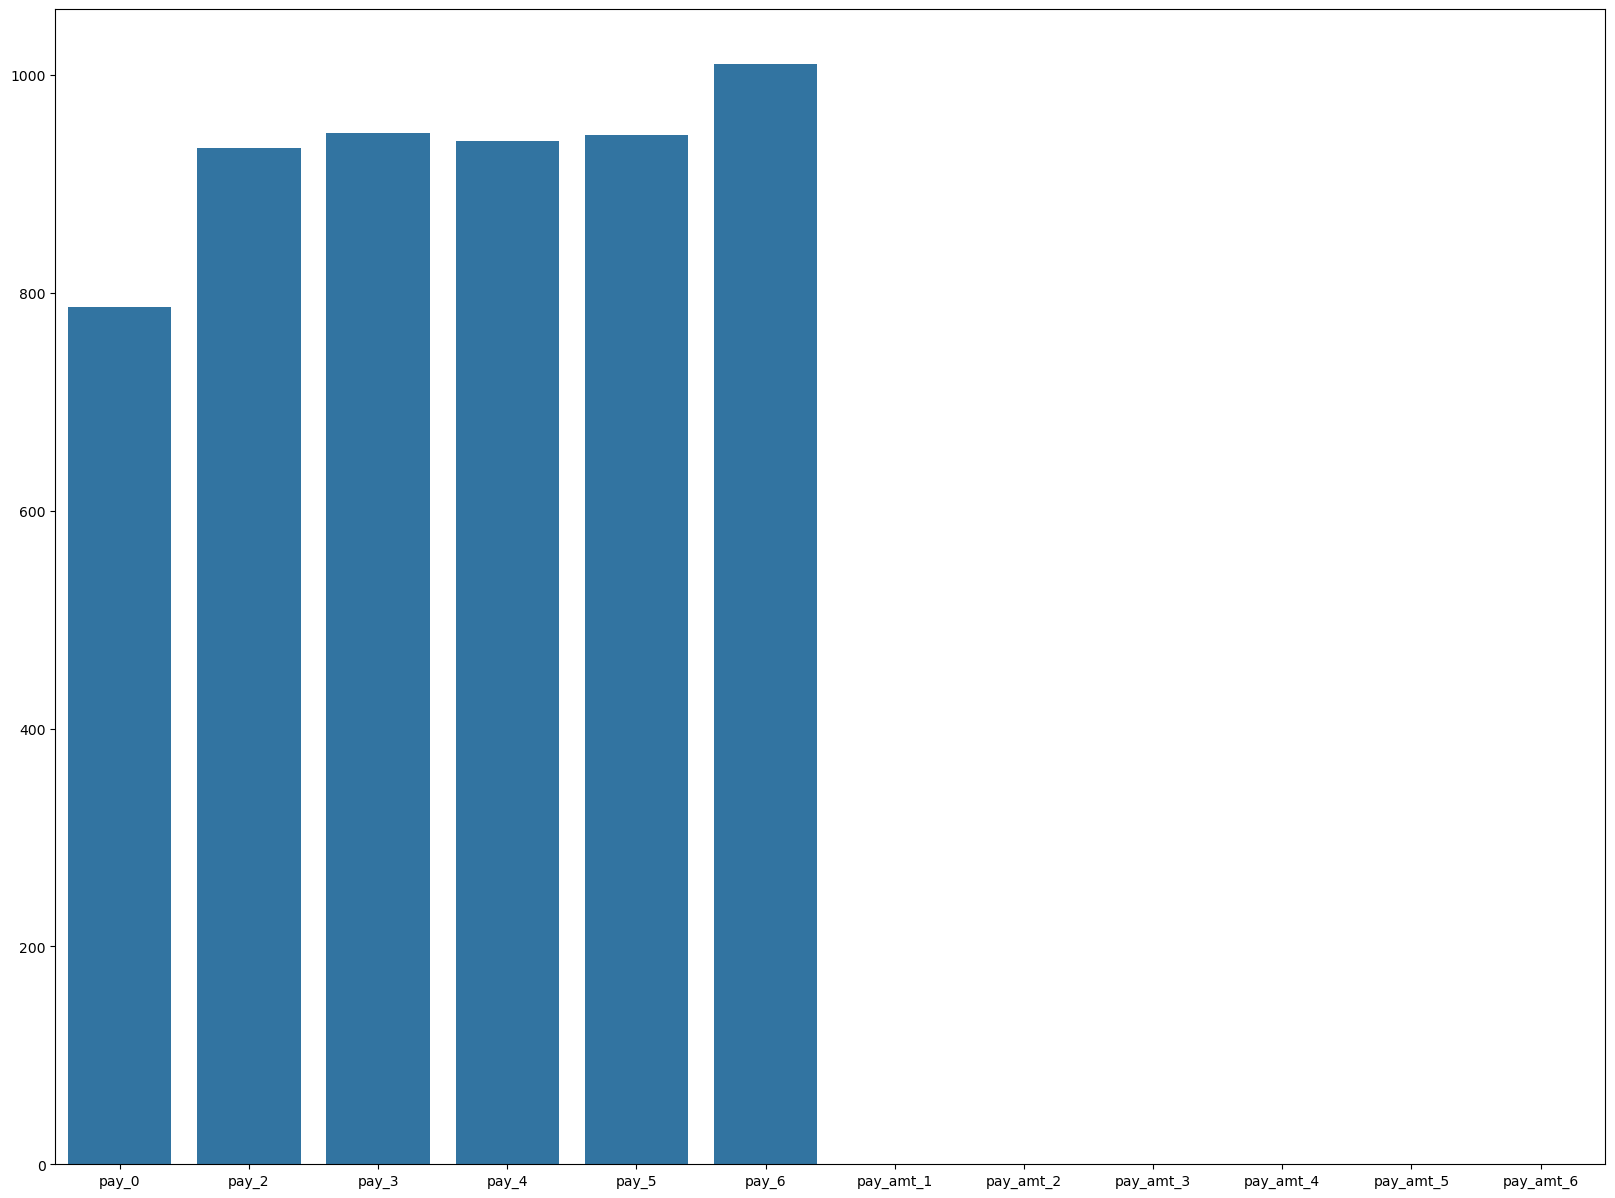

In [17]:
### Melihat banyaknya data pay yang negatif
pay = [i for i in database.columns if 'pay' in i and 'default' not in i]
plt.figure(figsize=(20,15))
sb.barplot(database[database[pay] < 0][pay].count())

Data pay_0, pay_2, pay_3, pay_4, pay_5, pay_6 memiliki data negatif dan pay_6 memiliki nilai negatif terbanyak dari semuanya. 

Data pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6 tidak memiliki nilai negatif.

### Melihat Banyak Data Unik

In [18]:
# Melihat banyak data unik di setiap kolom
pd.DataFrame([database.nunique()]).T

,0
limit_balance,59
sex,2
education_level,7
marital_status,4
age,49
pay_0,11
pay_2,10
pay_3,9
pay_4,10
pay_5,9


<Axes: >

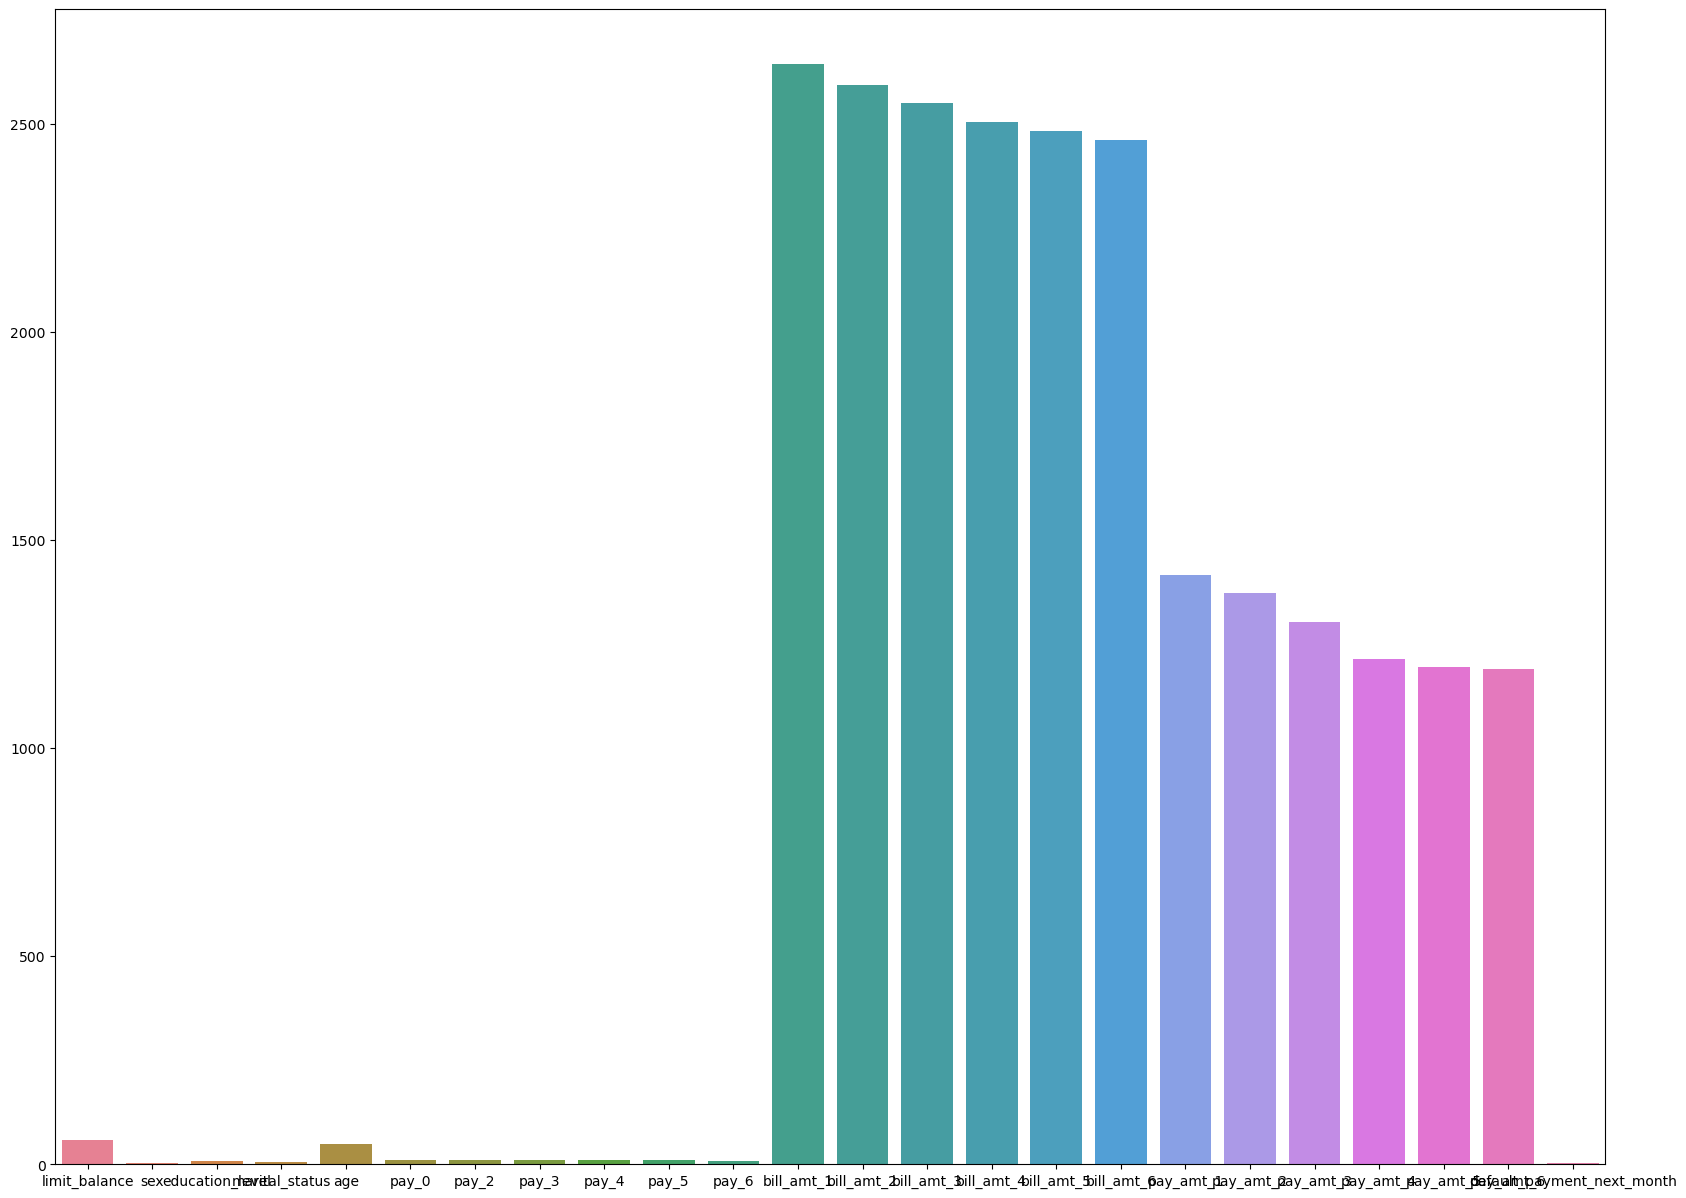

In [19]:
# Melihat visualisasi banyak data unik di setiap kolom
plt.figure(figsize=(20,15))
sb.barplot(pd.DataFrame([database.nunique()]))

data bill_amt dan pay_amt adalah data numerikal.

Selain data bill_amt dan pay_amt adalah data kategorikal.

### Melihat Korelasi Data

<Axes: >

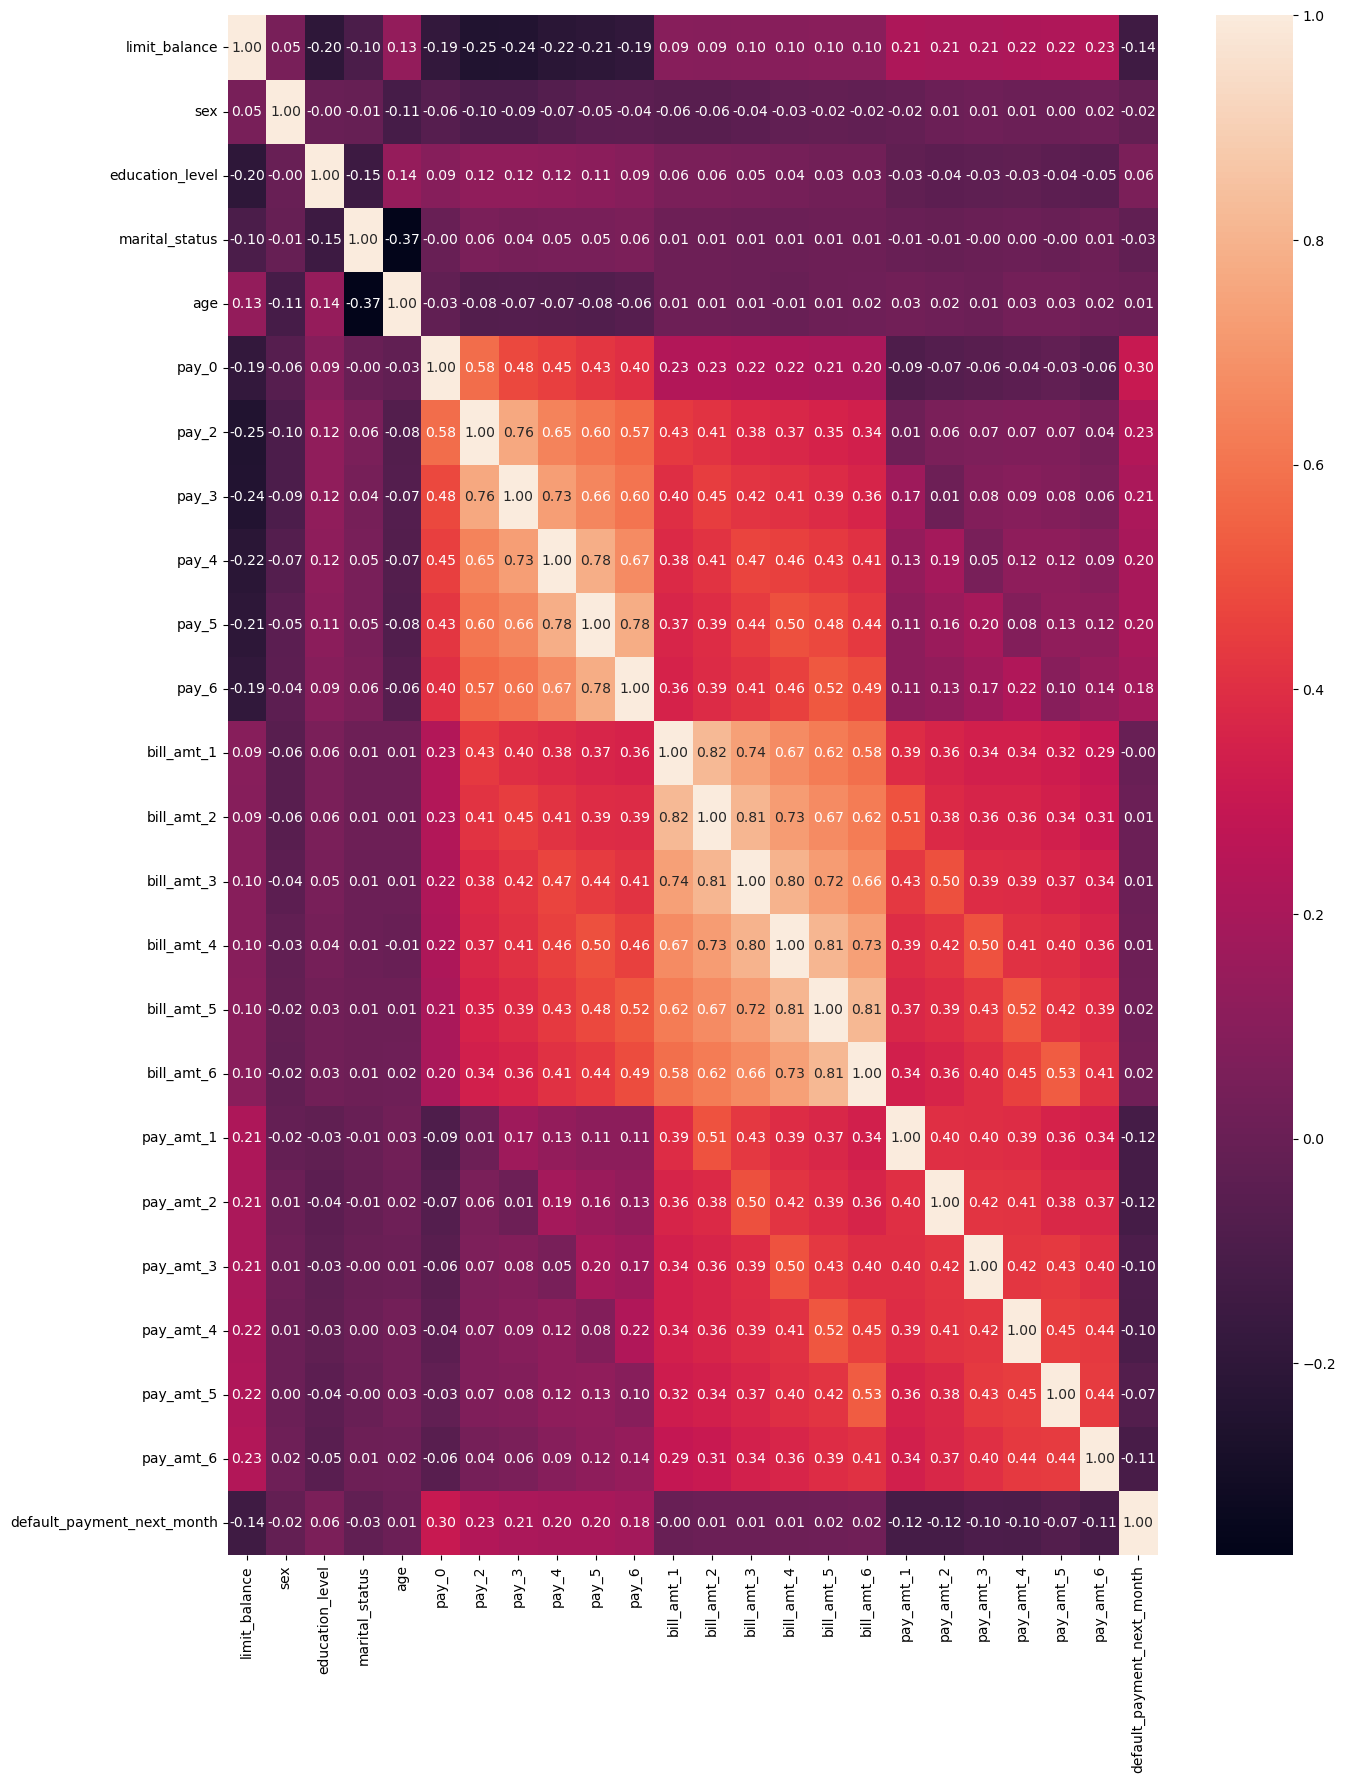

In [20]:
plt.figure(figsize=(15,20))
sb.heatmap(database.corr(method='kendall'),annot=True, fmt='.2f')

- bill_amt memiliki korelasi mendekati 0 dengan data target(tidak ada korelasi)
- data pay memiliki korelasi tinggi dengan data target
- data pay_amt memiliki korelasi tinggi dengan data target
- data limit balance memiliki korelasi tinggi, namun memiliki korelasi tinggi antar kolom(tidak dimasukan ke feature)

### Cek Kardinality

In [21]:
# Cek Kardinality
database.nunique()

limit_balance                   59
sex                              2
education_level                  7
marital_status                   4
age                             49
pay_0                           11
pay_2                           10
pay_3                            9
pay_4                           10
pay_5                            9
pay_6                            8
bill_amt_1                    2643
bill_amt_2                    2592
bill_amt_3                    2549
bill_amt_4                    2504
bill_amt_5                    2482
bill_amt_6                    2461
pay_amt_1                     1415
pay_amt_2                     1372
pay_amt_3                     1302
pay_amt_4                     1214
pay_amt_5                     1194
pay_amt_6                     1189
default_payment_next_month       2
dtype: int64

Kebanyakan data adalah numerikal kategorikal, maka akan menggunakan chi-contigency squared

### Cek Korelasi dengan Chi-Squared Contigency

In [22]:
# Melihat Korelasi data dari chi-contigency squared terhadap target
for i in database.columns:
    if len(database[i].unique()) <= 10 and 'default' not in i:
        print(f"{i}:{stats.chi2_contingency((pd.crosstab(database[i],database['default_payment_next_month']).values)).pvalue}")

sex:0.2545875974542288
education_level:2.776981079132354e-05
marital_status:0.3221207009667394
pay_2:5.2633741050198604e-79
pay_3:1.9052532791724626e-68
pay_4:4.726861856010754e-61
pay_5:1.6086706420083177e-60
pay_6:1.0683466082191313e-51


sex dan marital_status memiliki p-value < 0.5, maka data tersebut tidak memiliki relasi.

In [23]:
# Memasukan feature berdasarkan relasi
feature = [i for i in database.columns if 'pay' in i and 'default' not in i]
feature.extend(['education_level'])
feature

['pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'pay_amt_1',
 'pay_amt_2',
 'pay_amt_3',
 'pay_amt_4',
 'pay_amt_5',
 'pay_amt_6',
 'education_level']

### Melihat Banyak Data Unik pada Feature

<Axes: >

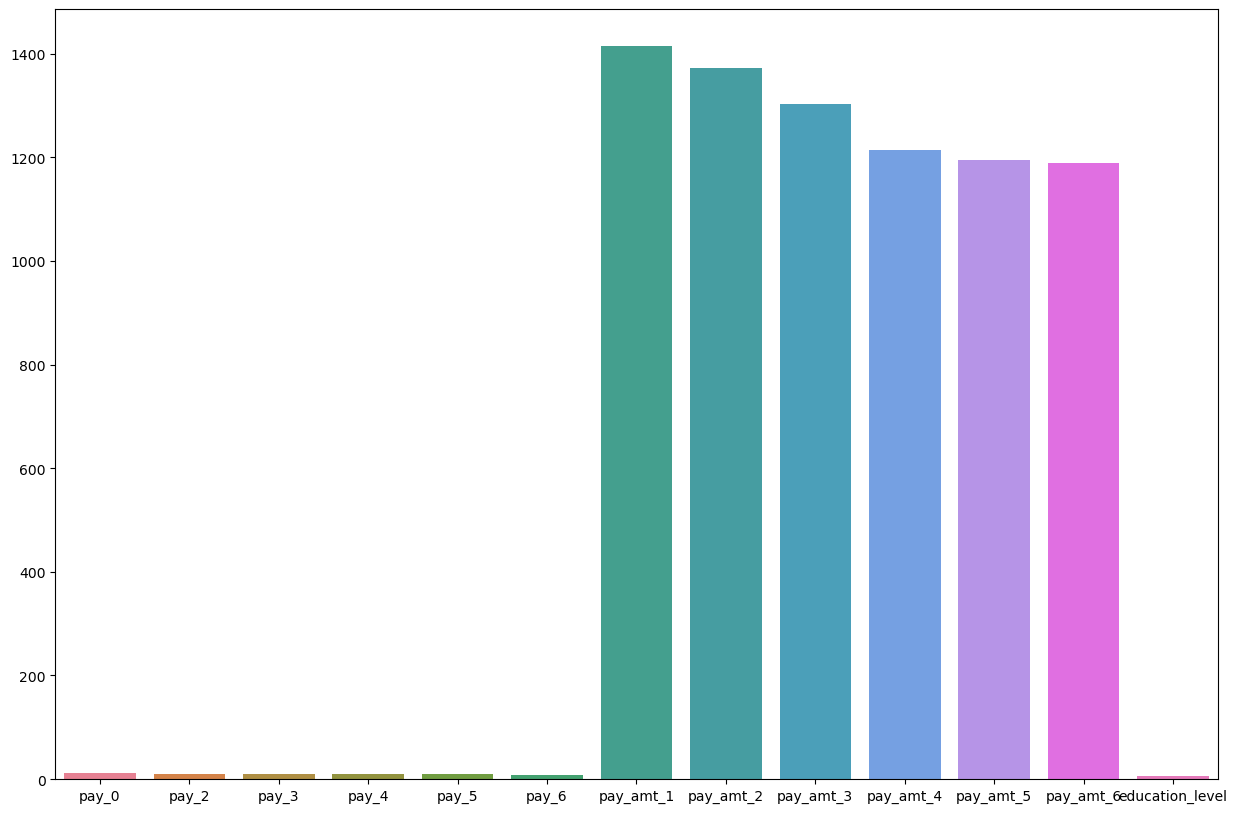

In [24]:
plt.figure(figsize=(15,10))
sb.barplot(pd.DataFrame([database[feature].nunique()]))

Feature kolom pay_amt adalah numerikal, sedangkan pay dan education adalah kategorikal

# Feature Engineering

### Data Splitting

In [25]:
#Data Splitting
X = database.drop(columns=['default_payment_next_month'])
y = database['default_payment_next_month']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

[X_train.shape,X_test.shape,y_train.shape,y_test.shape]

[(2075, 23), (890, 23), (2075,), (890,)]

### Feature Selection

In [26]:
# Mengambil data berdasarkan Feature Selection
X_train, X_test = X_train[feature], X_test[feature]
[X_train.shape,X_test.shape]

[(2075, 13), (890, 13)]

In [27]:
X_train.nunique()

pay_0                 9
pay_2                 8
pay_3                 9
pay_4                 9
pay_5                 9
pay_6                 8
pay_amt_1          1028
pay_amt_2          1004
pay_amt_3           951
pay_amt_4           900
pay_amt_5           878
pay_amt_6           861
education_level       7
dtype: int64

### Handling Outlier

In [28]:
#Melihat skewness dari setiap data
[X_train.skew(),X_test.skew()]

[pay_0               0.900988
 pay_2               0.816835
 pay_3               0.832260
 pay_4               0.926674
 pay_5               0.913009
 pay_6               0.861448
 pay_amt_1          12.120726
 pay_amt_2          27.112363
 pay_amt_3           7.792925
 pay_amt_4           8.108793
 pay_amt_5           9.446997
 pay_amt_6           9.856090
 education_level     0.950979
 dtype: float64,
 pay_0               0.991684
 pay_2               0.978304
 pay_3               1.191177
 pay_4               1.518983
 pay_5               1.407778
 pay_6               1.264380
 pay_amt_1           8.284509
 pay_amt_2           7.314853
 pay_amt_3           8.677633
 pay_amt_4           7.963401
 pay_amt_5          16.649823
 pay_amt_6           6.370461
 education_level     0.740622
 dtype: float64]

Skewness tinggi, maka data bisa dihandling dengan feature scaling RobustScaler

# Model Definition

### Mendefinisikan Model

In [29]:
# Define models
model = {
    "logic": Pipeline([('scaler', RobustScaler()), ('model', LogisticRegression(random_state=42))]),
    "knn": Pipeline([('scaler', RobustScaler()), ('model', KNeighborsClassifier())]),
    "svc": Pipeline([('scaler', RobustScaler()), ('model', SVC(random_state=42))])
}
model

{'logic': Pipeline(steps=[('scaler', RobustScaler()),
                 ('model', LogisticRegression(random_state=42))]),
 'knn': Pipeline(steps=[('scaler', RobustScaler()), ('model', KNeighborsClassifier())]),
 'svc': Pipeline(steps=[('scaler', RobustScaler()), ('model', SVC(random_state=42))])}

### Mendefinisikan Hyperparameter

In [30]:
# Define hyperparameters
hyperparam = {
    'logic': {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'model__C': [0.01, 0.1, 1.0],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'lbfgs', 'sag'],
        'model__max_iter': [100, 200]
    },
    'knn': {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'model__n_neighbors': [3, 5, 7, 9, 11],
        'model__p': [1, 2],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree']
    },
    'svc': {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'model__C': [0.01, 0.1, 1.0],
        'model__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    }
}

# Model Training

### Training model tanpa tuning

In [31]:
# Train model tanpa tuning
wo_model = {}
for key,modeling in model.items():
    wo_model[key] = modeling.fit(X_train,y_train)
wo_model

{'logic': Pipeline(steps=[('scaler', RobustScaler()),
                 ('model', LogisticRegression(random_state=42))]),
 'knn': Pipeline(steps=[('scaler', RobustScaler()), ('model', KNeighborsClassifier())]),
 'svc': Pipeline(steps=[('scaler', RobustScaler()), ('model', SVC(random_state=42))])}

### Training model dengan tunning

In [32]:
# Train model tuning
w_model = {}
for key, modeling in model.items():
    grid = GridSearchCV(modeling, hyperparam[key], cv=3)
    grid.fit(X_train, y_train)
    w_model[key] = grid.best_estimator_
w_model

{'logic': Pipeline(steps=[('scaler', RobustScaler()),
                 ('model',
                  LogisticRegression(C=0.1, penalty='l1', random_state=42,
                                     solver='liblinear'))]),
 'knn': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model',
                  KNeighborsClassifier(algorithm='ball_tree', n_neighbors=11))]),
 'svc': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', SVC(kernel='linear', random_state=42))])}

# Model Evaluation

In [33]:
#Fungsi Evaluasi
def eva(feature,target,model_train):
    ev = {
        'f1-score':[],
        'accuracy':[]
    }
    column=[]
    if len(model_train)> 1:
        for key, modeling in model_train.items():
            predict = modeling.predict(feature)
            column.append(key)
            ev['f1-score'].append(f1_score(target,predict))
            ev['accuracy'].append(accuracy_score(target,predict))
    return pd.DataFrame(ev,index=column).T

def full_eva(feature,target,model_train):
    for key, modeling in model_train.items():
        predict = modeling.predict(feature)
        print("="*20,key,"="*20)
        print(classification_report(target,predict))

def conf_matrix_show(feature,target,model_train):
    for key, modeling in model_train.items():
        prediction = modeling.predict(feature)
        cm = confusion_matrix(target,prediction)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.title(key)
        plt.show()

## Evaluasi Model Secara Lengkap

### Tanpa Tuning

In [34]:
## Evaluasi Model Secara Lengkap
print("="*20,"Train","="*20)
full_eva(X_train,y_train,wo_model)
print("="*20,"Test","="*20)
full_eva(X_test,y_test,wo_model)

==================== Train ====================
==================== logic ====================
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1619
           1       0.77      0.32      0.45       456

    accuracy                           0.83      2075
   macro avg       0.80      0.64      0.67      2075
weighted avg       0.82      0.83      0.80      2075

==================== knn ====================
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1619
           1       0.74      0.49      0.59       456

    accuracy                           0.85      2075
   macro avg       0.81      0.72      0.75      2075
weighted avg       0.84      0.85      0.84      2075



==================== svc ====================
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1619
           1       0.75      0.30      0.43       456

    accuracy                           0.82      2075
   macro avg       0.79      0.64      0.66      2075
weighted avg       0.81      0.82      0.79      2075

==================== Test ====================
==================== logic ====================
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       711
           1       0.67      0.26      0.38       179

    accuracy                           0.83       890
   macro avg       0.76      0.62      0.64       890
weighted avg       0.81      0.83      0.79       890

==================== knn ====================
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       711
           1       0.51      0.32      0.40       

### Dengan Tuning

In [35]:
## Evaluasi Model Secara Lengkap
print("="*20,"Train","="*20)
full_eva(X_train,y_train,w_model)
print("="*20,"Test","="*20)
full_eva(X_test,y_test,w_model)

==================== Train ====================
==================== logic ====================
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1619
           1       0.77      0.31      0.44       456

    accuracy                           0.83      2075
   macro avg       0.80      0.64      0.67      2075
weighted avg       0.82      0.83      0.80      2075



==================== knn ====================
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1619
           1       0.77      0.42      0.54       456

    accuracy                           0.85      2075
   macro avg       0.81      0.69      0.73      2075
weighted avg       0.84      0.85      0.83      2075

==================== svc ====================
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1619
           1       0.65      0.46      0.54       456

    accuracy                           0.83      2075
   macro avg       0.76      0.70      0.72      2075
weighted avg       0.82      0.83      0.82      2075

==================== Test ====================
==================== logic ====================
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       711
           1       0.67      0.25      0.37       

SVC yang telah di tunning adalah model yang terbaik dari semua model.

## Evaluasi Model Berdasarkan f1-score dan Akurasi

### Tanpa Tuning

In [36]:
# Melihat evaluasi train
eva(X_train,y_train,wo_model)

,logic,knn,svc
f1-score,0.447205,0.588859,0.429467
accuracy,0.828434,0.850602,0.824578


In [37]:
# Melihat Evaluasi test
eva(X_test,y_test,wo_model)

,logic,knn,svc
f1-score,0.377510,0.397260,0.338843
accuracy,0.825843,0.802247,0.820225


### Dengan Tuning

In [38]:
# Melihat evaluasi train
eva(X_train,y_train,w_model)

,logic,knn,svc
f1-score,0.438185,0.544681,0.543590
accuracy,0.826988,0.845301,0.828434


In [39]:
# Melihat Evaluasi test
eva(X_test,y_test,w_model)

,logic,knn,svc
f1-score,0.365854,0.442029,0.506494
accuracy,0.824719,0.826966,0.829213


Dari sini, bisa dikatakan SVC setelah tuning adalah model terbaik dengan f1-score untuk train dan test >= 50% dan akurasi >= 80%

## Evaluasi Model dengan Graphis Confusion Matrix

### Tanpa Tuning

#### Train

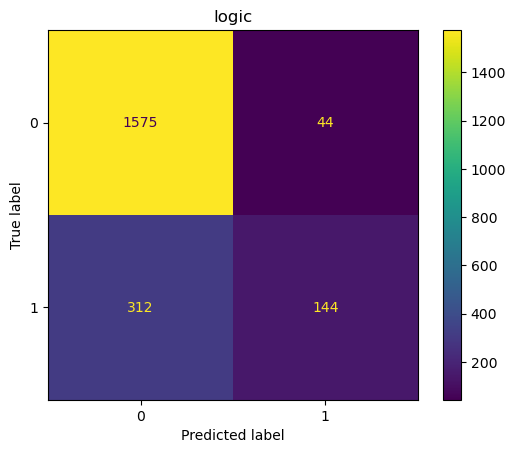

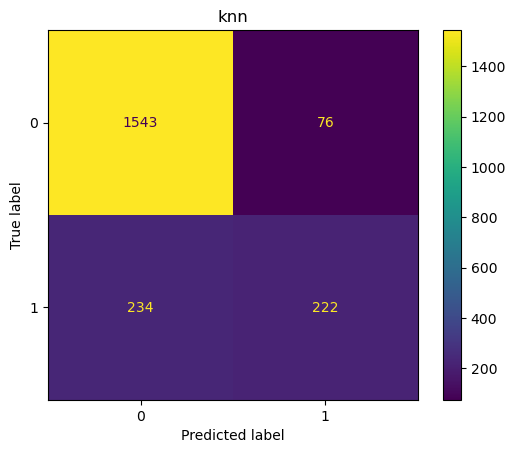

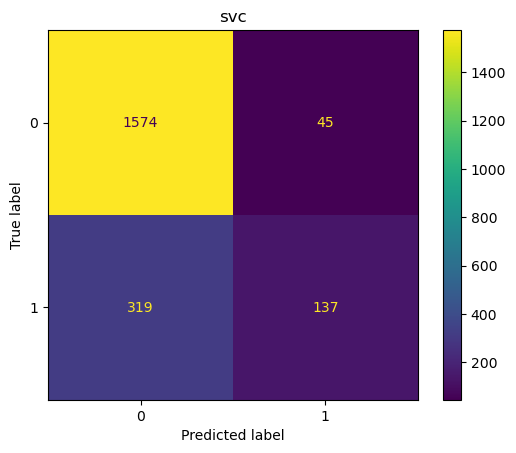

In [40]:
### Evaluasi Model dengan Graphis Confusion Matrix
conf_matrix_show(X_train,y_train,wo_model)

False Positive pada data train sebelum Tuning berkisar dari sekitar 200 sampai sekitar 300 dengan SVC memiliki banyak False Positive tertinggi (319).

#### Test

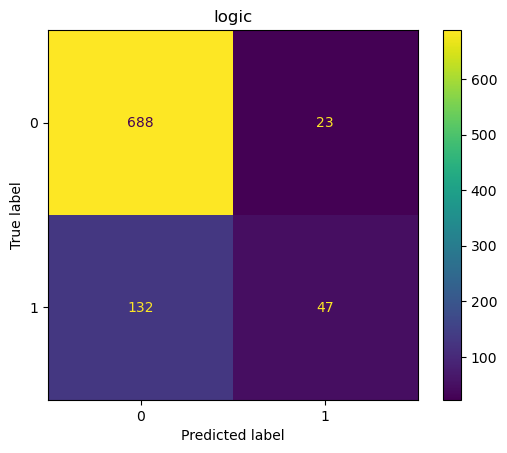

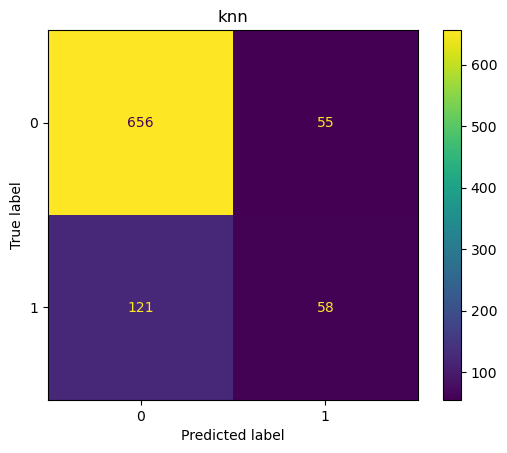

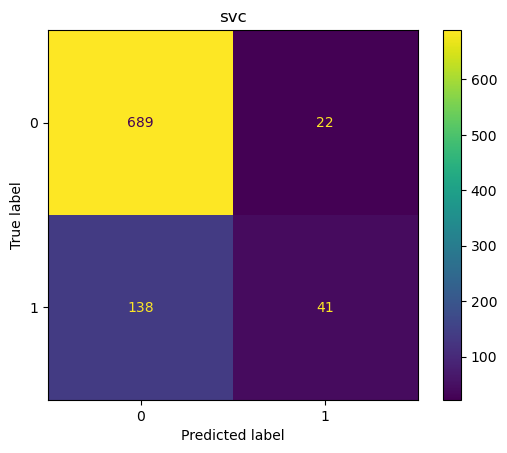

In [41]:
### Evaluasi Model dengan Graphis Confusion Matrix
conf_matrix_show(X_test,y_test,wo_model)

False Positive pada data test sebelum Tuning ada di sekitar 100-an dengan model SVC memiliki false positif tertinggi(138).

### Dengan Tuning

#### Train

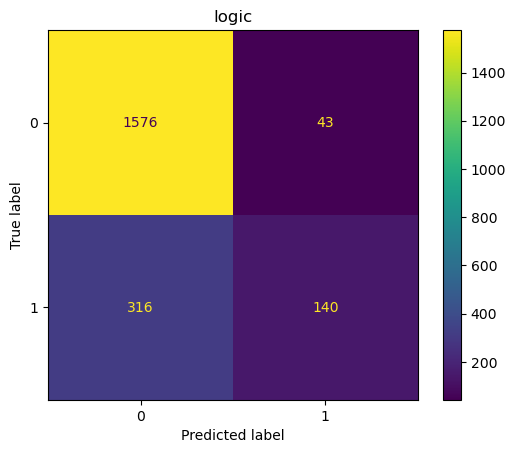

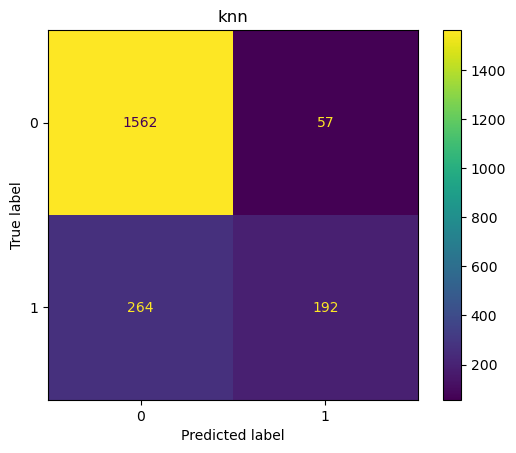

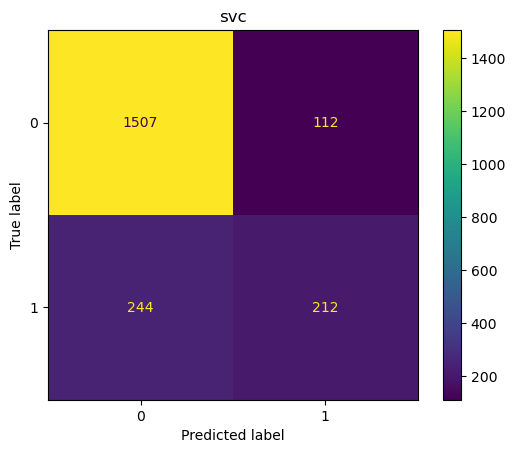

In [42]:
## Evaluasi Model dengan Graphis Confusion Matrix
conf_matrix_show(X_train,y_train,w_model)

Setelah Tuning, dalam data train, model Logistic Regression memiliki false positive tertinggi dengan jumlah 316 dan SVC memiliki false positive terendah dengan jumlah 244.

#### Test

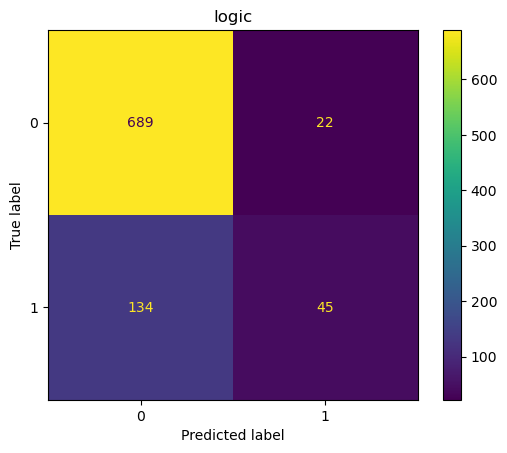

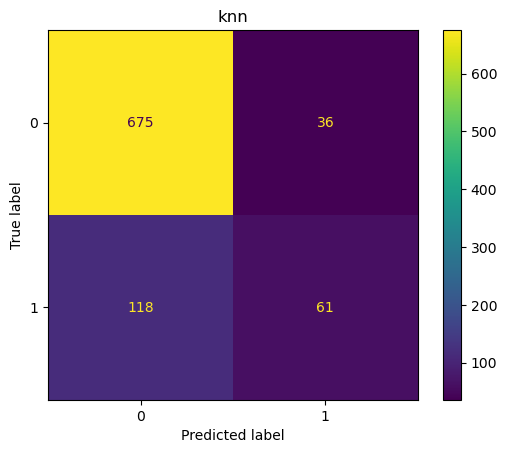

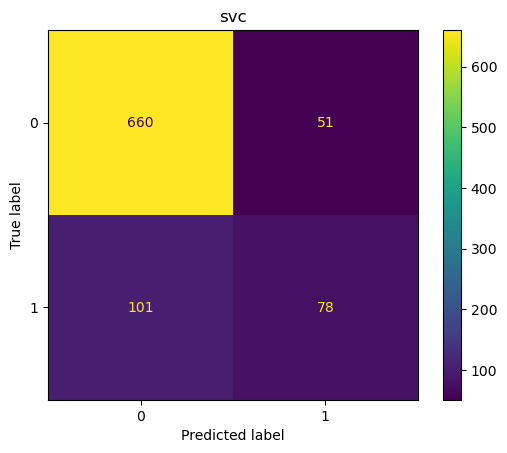

In [43]:
## Evaluasi Model dengan Graphis Confusion Matrix
conf_matrix_show(X_test,y_test,w_model)

Setelah Tuning, dalam data test, model Logistic Regression memiliki false positive tertinggi dengan jumlah 134 dan SVC memiliki false positive terendah dengan jumlah 101.

### Kesimpulan Model Evaluation

Model SVC setelah Tuning adalah model yang terbaik dengan false positive terendah dan nilai f1 untuk test dan train 50%-an dan akurasi 80%-an

# Model Saving

In [44]:
joblib.dump(w_model['svc'],'model.pkl')

json.dump(feature,open('feature.json','w'))

# Model Inference

In [45]:
# Mengambil Model
model_test = joblib.load('model.pkl')
model_test

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SVC(kernel='linear', random_state=42))])

In [46]:
# Membuat data dummy
test_column = json.load(open('feature.json','r'))
test_data = np.random.randint(1,10,13)
test_df = pd.DataFrame([test_data],columns=test_column)

In [48]:
# Menguji data
test_predict = model_test.predict(test_df)
test_df['predict'] = test_predict
test_df

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,education_level,predict
0,7,5,1,3,7,3,9,3,3,7,6,6,4,1


# Model Demo Link

Link: https://huggingface.co/spaces/AnonAnonymous/P1G5_Set_1_adam_nur

# Conceptual Problems

Jawab pertanyaan berikut:

1.    Apakah yang dimaksud dengan coeficient pada logistic regression?

2.    Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!

3.    Bagaimana cara memilih K yang optimal pada KNN ?

4.    Apa yang dimaksud dengan metrics-metrics berikut : Accuracy, Precision, Recall, F1 Score, dan kapan waktu yang tepat untuk menggunakannya ?


# Answer

1. Koefisien pada logistic regression adalah parameter untuk melihat seberapa besar pengaruh setiap fitur terhadap model yang diprediksi. Semakin besar koefisiennya maka semua fitur akan lebih besar pengaruhnya terhadap prediksi yang akan dihasilkan.

2. Kernel adalah Cara SVM melakukan pengelompokan data. Contohnya Polynomial dan Linear Kernel. Polynomial Kernel membuat batas yang sangat kompleks dan bebas membuat batasan garis(lurus, beliku-liku, dll) sedangkan Linear Hanya terbatas membuat batasan garis lurus dalam pengelompokan data.

3. Pencarian K bisa dilakukan dengan Cross-Validation.

4. 
- Akurasi:
        
        - Definisi: Akurasi adalah rasio prediksi yang benar (positif dan negatif) dibanding dengan total 
        prediksi ((TP+TN)/(TP+TN+FP+FN))
        
        - Case: Digunakan jika datanya seimbang
- Presisi:
        
        - Definisi: Rasio prediksi positif yang benar dibanding dengan total prediksi positif (TP/(TP+FP))
        
        - Case: Digunakan jika data difokuskan kepada False Positif
- Recall:
        
        - Definisi: Rasio prediksi positif yang benar dibanding dengan True Positif ditambah False Negatif (TP/(TP+FN))
        
        - Case: Digunakan ketika data yang difokuskan kepada False Negatif
- F1-Score:
        
        - Definisi: Rata-rata harmonik dari precision dan recall (2×Precision×RecallPrecision+Recall2×Precision+RecallPrecision×Recall​).
        
        - Case: Berguna ketika ingin keseimbangan antara precision dan recall. memberikan perhatian pada kasus di mana ada ketidakseimbangan kelas.

# Kesimpulan

Data 'default_payment_next_month' dipengaruhi oleh data pay, pay_amt dan education_level, dan model SVC dengan kernel linear adalah model yang cocok untuk memprediksi 'default_payment_next_month'.